## Logistic Regression

Assume we have a binary classification problem. We aim to fit a $h$ to a data set $S=\{(x_i,y_i)|i \in [m]\}$ that consists of $(x,y)$ pairs with $y \in \{0,1\}$. 

As in the previous lecture, we choose the hypothesis to be a linear function of the input: 

$\mathcal{H} := \{h: h(x) = w^\top x, w \in \mathbb{R}^k \}$.

For notational convenience, let us ignore the bias term as one can always append a constant one to the input vector $x$ to account for the bias.

The difference of the current setting is that the output space is discrete. Let us interpret the output of our hypothesis $h_i := w^\top x_i$ as follows:

 * Its sign indicates the class label. If $h_i > 0$, then the hypothesis predicts that $x_i$ belongs to class $1$. If $h_i < 0$, then the hypothesis predicts that $x_i$ belongs to class $0$.
 * Its magnitude $h_i$ indicates the confidence of the hypothesis about the class assignment.

 When interpreted this way, the hypothesis $h_i$ is called the **discriminant function**. While readily usable in its current shape, such a model is not easy to train. We desire a loss function that is differentiable with respect to the parameters $w$. The sign function is not differentiable. We can achieve differentiability by converting the discriminant function to a probability. Let $p_i$ denote the probability that $x_i$ belongs to class $1$, which is proportional to the magnitude of the discriminant function. That is:

$\log p_i \propto w^\top x_i$.

Considering also that the probability that $x_i$ is a member of class $0$ is $1-p_i$, we arrive at the following equation:

$\log \dfrac{p_i}{1-p_i} = w^\top x_i$.

Let us solve for $p_i$ stepwise:

\begin{align*} 
&\dfrac{p_i}{1-p_i} = e^{w^\top x_i}\\
&\Rightarrow p_i = e^{w^\top x_i} - p_i e^{w^\top x_i}\\
&\Rightarrow p_i + p_i e^{w^\top x_i} = e^{w^\top x_i}\\
&\Rightarrow p_i (1 + e^{w^\top x_i}) = e^{w^\top x_i}\\
&\Rightarrow p_i = \dfrac{e^{w^\top x_i}}{1 + e^{w^\top x_i}}\\
&\Rightarrow p_i = \dfrac{e^{w^\top x_i} e^{-w^\top x_i}}{(1 + e^{w^\top x_i})e^{-w^\top x_i}}\\
&\Rightarrow p_i = \dfrac{1}{1 + e^{-w^\top x_i}}.
\end{align*}

The result $\sigma(u) =  \dfrac{1}{1 + e^{-u}}$ has the form of a function known as the **sigmoid function**. The expression $\log (p_i/(1-p_i))$ is sometimes called the **log odds** or the **logit function**. It is the inverse of the sigmoid function: $\sigma^{-1}(p) = \log (p/(1-p))$ for some probability $p$. When $u := w^\top x_i$, the model is called the **logistic regression**.

We would like our hypothesis to maximize the true class probability of all data points in the data set. Since we assume our data points to be independent, we can maximize the probability of each data point separately. Hence, we can maximize the probability of the data set by maximizing the product of the probabilities of each data point

$\prod_{i=1}^m p_i^{y_i} (1-p_i)^{1-y_i}$.

This is equivalent to maximizing the sum of the logarithms of the probabilities of each data point. Hence, we can define the loss function as follows

$\mathcal{L}_{01}(w) = -\sum_{i=1}^m \log \sigma(w^\top x_i)^{y_i} (1-\sigma(w^\top x_i))^{1-y_i}$.

### Extension to multi-class classification

Let us quickly extend the above formulation to multi-class classification. Assume we have $C$ classes, that is aim to fit a $h$ to a data set $S=\{(x_i,y_i)|i \in [m]\}$ that consists of $(x,y)$ pairs with $y \in \{0,1,\ldots, C-1\}$. We will then need to model the class probabilities of $C$ different classes: $p_1, p_2, \ldots, p_C$:

$\log p_c = w_c^\top x_i$.

Solving for $p_c$ and assuring that the class probabilities sum up to one yields:

$\sigma(x)_c = \dfrac{e^{x_i}}{\sum_{j=1}^k e^{x_j}}$,

which is called the **softmax** function. The related loss function is then:

$\mathcal{L}_{CE}(W) = -\sum_{i=1}^m \log \sigma(w_{y_i}^\top x_i) = \sum_{i=1}^m \Big \{ -w_{y_i}^\top x_i + \log \Big ( \sum_{c=1}^C e^{w_c^T x_i} \Big )  \Big \}$.

where $W = [w_1 \ldots w_C]$ is a matrix of the weight vectors for each class. This loss function is called the **cross entropy loss**. We will revisit this loss and understand better why it is given this particular name.

Let us take the well-known **Iris** data set as an example. Our task is to classify the iris flowers into three species. The data set is available in the sklearn library. The data set consists of 150 data points. Each data point has four features: sepal length, sepal width, petal length, and petal width. The data points are labeled as one of the three species: i) setosa, ii) versicolor, and iii) virginica. The data set is balanced: There are 50 data points for each species.


In [246]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim

X, y = load_iris(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

Let us put together what we learned thus far to make up an as general algorithm as possible. Strictly speaking, let us use the cross-entropy loss for empirical risk minimization and use an $L_p$ regularizer with tunable $p$ to control the complexity of the model. The resulting optimization problem is:

$L(W) := L_{CE}(W) + \lambda \sum_{c=1}^C  ||w_c||_p$.

In [247]:
class GeneralizedLinearClassifier(nn.Module):
    def __init__(self, n_dims, lambda_coef=1, p=2, n_classes=3):
        super(GeneralizedLinearClassifier, self).__init__()
        self.lambda_coef = lambda_coef
        self.weight = nn.Parameter(th.randn((n_dims,n_classes)))
        self.bias = nn.Parameter(th.randn((n_classes)))
        self.p = p

    def predict(self, input):
        return input @ self.weight + self.bias

    def learn(self, inputs, labels, num_steps=1):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.001)

        for ii in  range(num_steps):
            predictions = self.predict(inputs)
            loss = F.cross_entropy(predictions, labels) \
                  + (self.weight.abs()**self.p).sum()*self.lambda_coef
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

Let us train our model next and plot its learning curve, i.e. how its error changes across iterations.

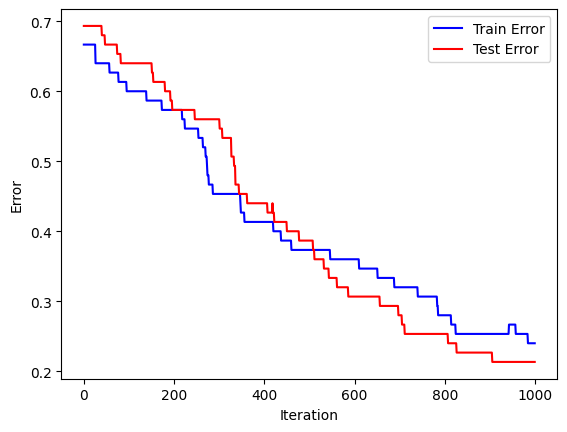

In [ ]:
# Convert data into the Torch format
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).long()
y_test = torch.tensor(y_test).long()

# z-score normalization
m = th.mean(X_train,axis=0)
std = th.std(X_train,axis=0)
X_train = (X_train-m)/std
X_test = (X_test-m)/std

# Train our model
model_glc = GeneralizedLinearClassifier(n_dims=X_train.shape[1],
                                        lambda_coef=1, p=2)
# Number of gradient descent iterations
num_iterations = 1000

# Collect the train and test errors here.
train_errors = np.zeros(num_iterations)
test_errors = np.zeros(num_iterations)

for ii in  range(num_iterations):
    model_glc.learn(X_train, y_train)

    predictions = model_glc.predict(X_train)
    pred_class = th.argmax(predictions, dim=1)
    train_errors[ii] = (pred_class != y_train.reshape(-1)).float().mean()
    
    # Test our model
    predictions = model_glc.predict(X_test)
    pred_class = th.argmax(predictions, dim=1)
    test_errors[ii] = (pred_class != y_test.reshape(-1)).float().mean()

# Plot the learning curve
plt.plot(np.arange(num_iterations),train_errors,'b-', label="Train Error")
plt.plot(np.arange(num_iterations),test_errors,'r-', label="Test Error")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.legend(loc="upper right")
plt.show()

## Performance Metrics for Classification

The goal of classification is to recognize a pattern, e.g. an object. From the viewpoint of a single object type, there can be four different outcomes of a classification task:

 * True Positive (TP): The object is correctly classified as positive.
 * False Positive (FP): The object is incorrectly classified as positive.
 * True Negative (TN): The object is correctly classified as negative.
 * False Negative (FN): The object is incorrectly classified as negative.

Let us make a matrix of these possible outcomes as a latex table:

|                     | **Predicted Positive** | **Predicted Negative** |
|---------------------|------------------------|------------------------|
| **Actual Positive** | TP                     | FN                     |
| **Actual Negative** | FP                     | TN                     |

The version of this table where its entries are filled with the number of data points that fall into each category is called a **confusion matrix**. We can compute many performance metrics from the confusion matrix: 

  1. **Accuracy**: (TP + TN) / (TP + FP + TN + FN), the ratio of the number of correctly classified objects to the total number of objects.
  2. **Precision**: TP / (TP + FP), the ratio of the number of correctly classified objects to the number of objects classified as the object type.
  3. **Recall**: TP / (TP + FN), the ratio of the number of correctly classified objects to the number of objects that are actually of the object type.
  4. **F1 score**: 2 $\times$ Precision $\times$ Recall / (Precision + Recall), the harmonic mean of the precision and the recall.
  5. **False Positive Rate**: FP / (FP + TN), the ratio of the number of objects that are not of the object type but classified as the object type to the total number of objects that are not of the object type.

  The rationale behind the F1 score is hat precision and recall are rates. Harmonic mean is a more sensible score to take the average of multiple rates. Consider a car that travels a distance $d$ with speed $x$ and returns with speed $y$. The average speed of the whole travel is
  
  $\frac{2d}{\frac{d}{x}+\frac{d}{y}} = \frac{2}{\frac{1}{x}+\frac{1}{y}}$
  
  which is the harmonic mean of $x$ and $y$. In words, harmonic mean is the reciprocal of the average of the reciprocals of a set of quantities.
  
  One can calculate the confusion matrix also for more than two classes. Let us see how it looks like for the Iris data set.

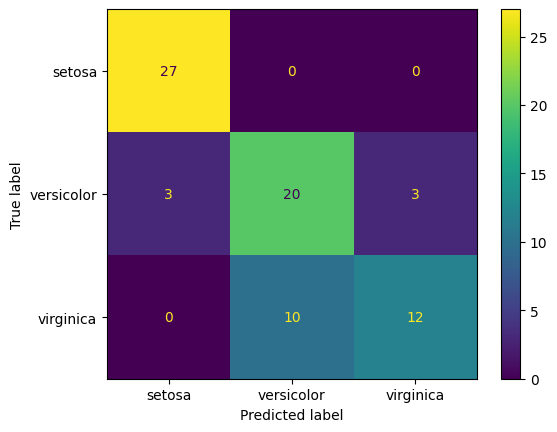

In [249]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm= confusion_matrix(y_test.detach().numpy(), pred_class.detach().numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                display_labels=['setosa','versicolor','virginica'])

disp.plot()
plt.show()

Except for accuracy, the other four performance metrics need to be calculated separately for each class. For instance, let us calculate them for setosa.

In [250]:
precision_setosa = cm[0,0]/(cm[0,0]+cm[1,0]+cm[2,0]) # sum towards the column
recall_setosa = cm[0,0]/(cm[0,0]+cm[0,1]+cm[0,2]) # sum towards the row
print("Precision: ", precision_setosa)
print("Recall: ", recall_setosa)
print("F1: ", 2*precision_setosa*recall_setosa/(precision_setosa+recall_setosa))

Precision:  0.9
Recall:  1.0
F1:  0.9473684210526316


Another important performance metric is **Receiver Operating Characeteristics (ROC)**. It is a plot of the true positive rate (TPR) against the false positive rate (FPR) for all possible thresholds applicable on the discriminant function. The **Area Under the ROC curve (AUC)** is a measure of the performance of the classifier. The higher the AUC, the better the classifier. A perfect classifier has an AUC of 1. A classifier that performs no better than random guessing has an AUC of 0.5.

Let us plot the ROC curve for the Iris data set.

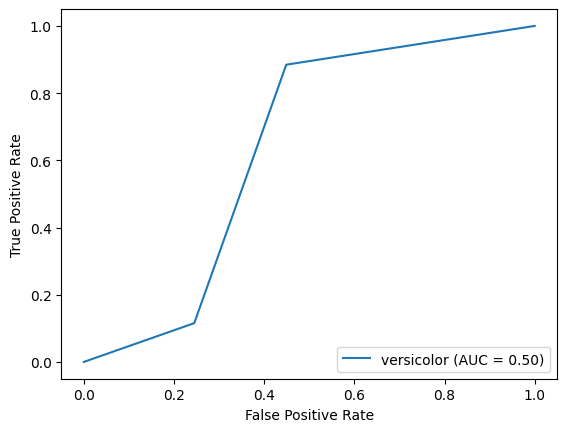

In [253]:
from sklearn.metrics import roc_curve, RocCurveDisplay

roc_curve_setosa = roc_curve(y_test.detach().numpy(), 
                            pred_class.detach().numpy(), pos_label=1)

disp = RocCurveDisplay(fpr=roc_curve_setosa[0], tpr=roc_curve_setosa[1], 
                       roc_auc=0.5, estimator_name='versicolor')

disp.plot()
plt.show()

**REMARK:** Accuracy is a meaningful performance metric only when the classes are evenly distributed. The cases when the classes are not evenly distributed are called **imbalanced classification problems**. In such cases, we need to use other metrics such as precision, recall, and F1 score.

## K-Fold Cross Validation

As noticeable in the above example, the observed performance may depend greatly on the particular train-test split. To mitigate this problem, we can use **K-fold cross validation**. The idea is to split the data set into $K$ folds. Then, we train the model on $K-1$ folds and test it on the remaining fold. We repeat this process $K$ times, each time using a different fold as the test set. The final performance metric is the average of the performance metrics obtained in each iteration.

## K-Nearest Neighbors (kNN) Classifier

The k-nearest neighbors classifier assigns a query point to the class of the majority of its $k$ nearest neighbors. It is a **non-parametric classifier**, that is it does not represent the model with a fixed number of parameters. Instead it memorizes the whole training data and uses it to make predictions. The number of neighbors $k$ is a hyperparameter of the model. While being a strong classifier, its prediction-time complexity is unacceptable: $O(m)$, where $m$ is the number of training data points.

One can implement a kNN in various ways. Given a query point $x$, one can find its $k$ nearest neighbors $Ne(x;k) = \{ (x_i, y_i) : [k] \}$ in the training data set and assign $x$ to the class of the majority of its $k$ nearest neighbors:

$\hat{y} = \arg \max_{c \in [C]} \sum_{i=1}^k \mathbb{1}(y_i = c)$.

One can also assign a weight to each neighbor inversely proportional to its distance to the query point and assign $x$ to the class of the majority of its $k$ nearest neighbors weighted by the inverse of their distances to $x$.

$\hat{y} = \arg \max_{c \in [C]} \sum_{i=1}^k \mathbb{1}(y_i = c) \dfrac{1}{d(x,x_i)}$

for some distance function $d$.

The **Voronoi cell** of a point $x$ is the set of points whose nearest neighbor is $x$. The Voronoi cells of the training data points form a partition of the input space. The decision boundary of a 1-nearest neighbor classifier is the set of points that are equidistant to two or more training data points. The decision boundary of a k-nearest neighbor classifier is the set of points that are equidistant to $k$ or more training data points. See an illustration from the Iris data set below.

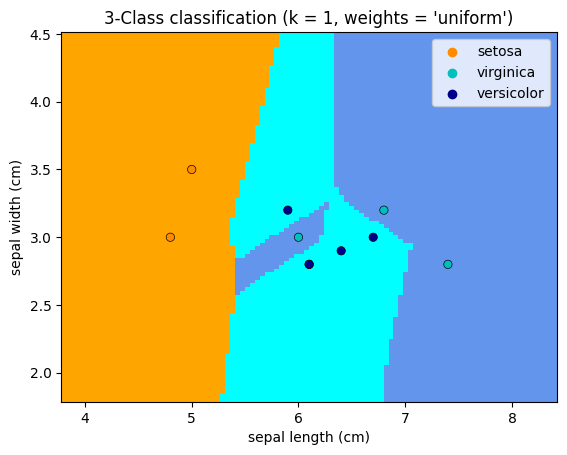

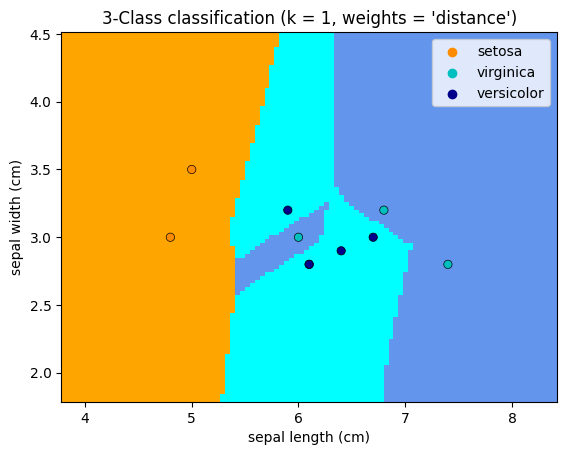

In [252]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

from sklearn import datasets, neighbors
from sklearn.inspection import DecisionBoundaryDisplay

n_neighbors = 1

iris = datasets.load_iris()

idx = np.random.permutation(iris.data.shape[0])
X = iris.data[idx[:10], :2]
y = iris.target[idx[:10]]

# Create color maps
cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue"])
cmap_bold = ["darkorange", "c", "darkblue"]

for weights in ["uniform", "distance"]:
    # weights=uniform: All points in each neighborhood are weighted equally
    # weights=distance: weight points by the inverse of their distance
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    _, ax = plt.subplots()
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        cmap=cmap_light,
        ax=ax,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=iris.feature_names[0],
        ylabel=iris.feature_names[1],
        shading="auto",
    )

    # Plot also the training points
    sns.scatterplot(
        x=X[:, 0],
        y=X[:, 1],
        hue=iris.target_names[y],
        palette=cmap_bold,
        alpha=1.0,
        edgecolor="black",
    )
    plt.title(
    "3-Class classification (k = %i, weights = '%s')" % (n_neighbors, weights)
    )

plt.show()